In [4]:
!pip install sklearn tqdm

     |████████████████████████████████| 76 kB 2.4 MB/s eta 0:00:011
     |████████████████████████████████| 26.7 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 235 kB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1308 sha256=4d64bb2eeb97fe4a35ec177c1e3a77356445af01fb600af6854c4a17d96e03af
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
# adapted from https://scikit-learn.org/0.19/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier


# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
default_parameters_sgd = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

def run_model(remove=(), categories=None, clf=SGDClassifier(), parameters=default_parameters_sgd):
    print("Loading 20 newsgroups dataset for categories:")
    print(categories)
    
    data = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
    print("%d documents" % len(data.filenames))
    print("%d categories" % len(data.target_names))
    print()
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf),
    ])

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
if __name__ == "__main__":
    categories = [
        'alt.atheism',
        'talk.religion.misc',
    ]
    #categories = None
    
    print('### no preprocessing ###')
    run_model(categories=categories)

    print()
    print('### with headers, footers, quotes (metadata) removed ###')
    run_model(categories=categories, remove=(('headers', 'footers', 'quotes')))
    
    #print()
    #print('### with headers, footers, quotes (metadata) removed ###')
    #run_model(categories=categories,
    #          remove=(('headers', 'footers', 'quotes')),
    #          clf=LogisticRegression(),
    #          parameters={
    #              'vect__max_df': (0.5, 0.75, 1.0),
    #              #'vect__max_features': (None, 5000, 10000, 50000),
    #              'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #              #'tfidf__use_idf': (True, False),
    #              #'tfidf__norm': ('l1', 'l2'),
    #          })
    

2022-02-19 13:00:04,276 INFO Downloading 20news dataset. This may take a few minutes.
2022-02-19 13:00:04,277 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Automatically created module for IPython interactive environment
### no preprocessing ###
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 10.802s

Best score: 0.953
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)

### with headers, footers, quotes (metadata) removed ###
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1)

In [12]:
import numpy as np

from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

import matplotlib.pyplot as plt

In [13]:
categories = ['alt.atheism', 'soc.religion.christian'] 

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, 
                                      categories=categories,)

print (newsgroups_train.target_names)
print (len(newsgroups_train.data))

#print (newsgroups_train.data[1])
print("\n".join(newsgroups_train.data[0].split("\n")[10:15]))

['alt.atheism', 'soc.religion.christian']
1079
   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Project Judaica Foundation, will be held in the


In [14]:
%%time

texts = []

labels=newsgroups_train.target
texts = newsgroups_train.data

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

print (sequences[0][:10])

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print (data.shape)
print (data[0][200:250])

labels = to_categorical(np.array(labels))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

VALIDATION_SPLIT = 0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices) 
data = data[indices] 
labels = labels[indices] 
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples] 
y_train = labels[:-nb_validation_samples] 
x_val = data[-nb_validation_samples:] 
y_val = labels[-nb_validation_samples:] 

print (x_train.shape)
print (y_train.shape)

print('Number of positive and negative reviews in traing and validation set ') 
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

[19, 8762, 3621, 11894, 58, 8762, 3621, 43, 1472, 2]
Found 20030 unique tokens.
(1079, 1000)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    19  8762  3621 11894    58  8762  3621
    43  1472     2  2130     3   189   450  1001  3622  2980  1682   476
   627    50]
Shape of data tensor: (1079, 1000)
Shape of label tensor: (1079, 2)
(864, 1000)
(864, 2)
Number of positive and negative reviews in traing and validation set 
[396. 468.]
[ 84. 131.]
CPU times: user 548 ms, sys: 66 µs, total: 548 ms
Wall time: 543 ms


In [15]:
%%time
embeddings_index = {}

path = './'

f = open(path+'glove.6B.100d.txt')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print ()
print ('Found %s word vectors.' % len(embeddings_index))

400000it [00:13, 28663.99it/s]


Found 400000 word vectors.
CPU times: user 9.42 s, sys: 848 ms, total: 10.3 s
Wall time: 15.6 s


In [16]:
EMBEDDING_DIM = 100

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print (embedding_matrix.shape)
print (embedding_matrix[0][:10])

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') 
embedded_sequences = embedding_layer(sequence_input) 
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences) 
l_pool1 = MaxPooling1D(5)(l_cov1) 
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1) 
l_pool2 = MaxPooling1D(5)(l_cov2) 
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2) 
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling

l_flat = Flatten()(l_pool3) 
l_dense = Dense(128, activation='relu')(l_flat) 
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=10, batch_size=128)   

(20031, 100)
[0.03015782 0.25220209 0.44844341 0.66403425 0.44003651 0.44600341
 0.79208292 0.33986422 0.51144624 0.96613044]
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 100)         2003100   
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 195, 128)          82048     
                                                                 

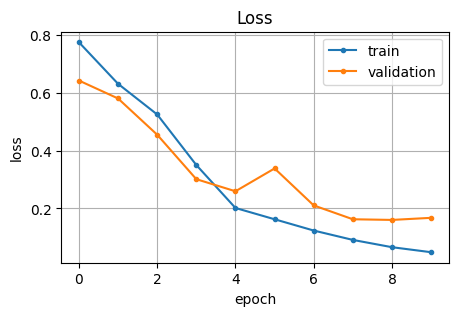

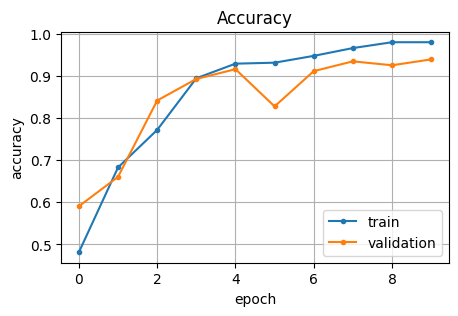

In [17]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['acc'], marker='.', label='train')
plt.plot(history.history['val_acc'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()